<a href="https://colab.research.google.com/github/hevertonvalerio/Challenge/blob/main/forecast_tickers_Xgboost_exponential_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.2 MB/s eta 0:00:00


In [2]:
## Preâmbulo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.api as qqplot
import random
import yfinance as yf
import os

# bibiotecas Time_series
import matplotlib.dates as mdates
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

import scipy.stats as stats

## importando também o pmdarima, para usar a função auto.arima, que pode otimizar nossos resultados c este tipo de série tempora
import pmdarima as pm

In [6]:
## Estilo do plot:

#plt.style.use([ 'grayscale' , '/content/ativos_csv_2023.csv' ])

In [3]:
df = pd.read_csv('/content/ativos_csv_2023.csv')

df.head()

df.set_index('Date', inplace= True)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')


df.tail()

,AVIR,WOLF,TGI,LMND,RLAY,SPR,ZYME,ERAS,BA,GE,...,NMIH,FOLD,RKLB,IOVA,CPRX,CCCC,NTLA,BEAM,NVAX,ARDX
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-08,3.41,9.51,11.69,15.730000,6.25,32.250000,12.53,2.52,154.649994,187.470001,...,41.189999,10.04,9.41,9.72,20.080000,5.13,17.889999,23.260000,13.04,5.96
2024-10-09,3.40,9.98,11.65,16.350000,6.41,31.740000,12.73,2.60,149.369995,189.279999,...,40.830002,10.16,9.45,9.61,19.969999,5.06,17.650000,23.440001,12.68,5.87
2024-10-10,3.34,9.50,14.12,16.920000,6.58,30.920000,12.84,2.56,146.619995,188.119995,...,40.639999,10.05,9.39,9.47,19.910000,5.30,17.790001,23.030001,12.91,6.04
2024-10-11,3.48,11.48,15.00,17.389999,6.80,31.459999,13.20,2.75,151.020004,191.160004,...,40.869999,10.50,9.70,9.74,20.200001,5.46,18.580000,24.719999,12.53,6.04
2024-10-14,3.53,11.38,14.81,17.540001,6.75,31.190001,13.30,2.75,148.990005,192.630005,...,41.000000,10.42,9.88,9.77,20.639999,5.88,19.510000,26.590000,12.62,5.99


In [4]:
## Importando Bitcoin; fazendo join em 'df'

bit_df = yf.download('BTC-USD', start = '2024-01-02')

bit_df = bit_df[['Close']].rename(columns = {'Close':'BTC'})

bit_df.index = pd.to_datetime(bit_df.index, format = '%Y-%m-%d')

df.index = pd.to_datetime(df.index)

df = df.merge(bit_df, left_index=True, right_index=True, how = 'left')

df.tail()

[*********************100%***********************]  1 of 1 completed


,AVIR,WOLF,TGI,LMND,RLAY,SPR,ZYME,ERAS,BA,GE,...,FOLD,RKLB,IOVA,CPRX,CCCC,NTLA,BEAM,NVAX,ARDX,BTC
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-08,3.41,9.51,11.69,15.730000,6.25,32.250000,12.53,2.52,154.649994,187.470001,...,10.04,9.41,9.72,20.080000,5.13,17.889999,23.260000,13.04,5.96,62131.968750
2024-10-09,3.40,9.98,11.65,16.350000,6.41,31.740000,12.73,2.60,149.369995,189.279999,...,10.16,9.45,9.61,19.969999,5.06,17.650000,23.440001,12.68,5.87,60582.101562
2024-10-10,3.34,9.50,14.12,16.920000,6.58,30.920000,12.84,2.56,146.619995,188.119995,...,10.05,9.39,9.47,19.910000,5.30,17.790001,23.030001,12.91,6.04,60274.500000
2024-10-11,3.48,11.48,15.00,17.389999,6.80,31.459999,13.20,2.75,151.020004,191.160004,...,10.50,9.70,9.74,20.200001,5.46,18.580000,24.719999,12.53,6.04,62445.089844
2024-10-14,3.53,11.38,14.81,17.540001,6.75,31.190001,13.30,2.75,148.990005,192.630005,...,10.42,9.88,9.77,20.639999,5.88,19.510000,26.590000,12.62,5.99,66046.125000


In [5]:
## Definindo o tsplot, como no livro:
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None,xlabel=None,set_major=None):

  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()

  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if xlabel is not None:
    ax.set_xlabel(xlabel)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))

  if label is not None:
    plt.legend()

  if set_major is not None:
    ax.xaxis.set_major_locator(set_major)
  plt.tight_layout()

  return

In [6]:
avir_df = df[['AVIR']]

avir_df.head()

,AVIR
Date,
2023-01-03,4.81
2023-01-04,4.78
2023-01-05,4.69
2023-01-06,4.70
2023-01-09,4.68


In [7]:
## Fazendo o train-test split (10)

len_df = len(avir_df)
train_size = int(len_df*0.8)

#print(len_df)

train = avir_df.iloc[:train_size]
train.index = pd.to_datetime(train.index)
train = train.asfreq('D', method = 'ffill')

test = avir_df.iloc[train_size:]
test.index = pd.to_datetime(test.index)
test = test.asfreq('D', method = 'ffill')

print(train)
print(test)

            AVIR
Date            
2023-01-03  4.81
2023-01-04  4.78
2023-01-05  4.69
2023-01-06  4.70
2023-01-07  4.70
...          ...
2024-06-01  3.67
2024-06-02  3.67
2024-06-03  3.89
2024-06-04  3.77
2024-06-05  3.96

[520 rows x 1 columns]
            AVIR
Date            
2024-06-06  3.80
2024-06-07  3.70
2024-06-08  3.70
2024-06-09  3.70
2024-06-10  3.79
...          ...
2024-10-10  3.34
2024-10-11  3.48
2024-10-12  3.48
2024-10-13  3.48
2024-10-14  3.53

[131 rows x 1 columns]


In [8]:
avir_df = avir_df.asfreq('D', method = 'ffill')

merged_df = avir_df.copy() #pd.merge(df_final, avir_df, how='left', right_index=True, left_index=True)

merged_df.tail(10)

#merged_df = merged_df.drop('ARIMA', axis = 1)

,AVIR
Date,
2024-10-05,3.46
2024-10-06,3.46
2024-10-07,3.41
2024-10-08,3.41
2024-10-09,3.40
2024-10-10,3.34
2024-10-11,3.48
2024-10-12,3.48
2024-10-13,3.48


In [9]:
## Calculando as Trends
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
#from statsmodels.tsa.seasonal import seasonal_decompose

## Estatísticas de ajuste:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def des_optimizer(train, alphas, betas, step=int(len(test))):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_trend=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

In [10]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 0.5006
alpha: 0.01 beta: 0.11 mae: 1.6327
alpha: 0.01 beta: 0.21 mae: 0.7411
alpha: 0.01 beta: 0.31 mae: 2.345
alpha: 0.01 beta: 0.41 mae: 2.0648
alpha: 0.01 beta: 0.51 mae: 0.6303
alpha: 0.01 beta: 0.61 mae: 2.5634
alpha: 0.01 beta: 0.71 mae: 1.2394
alpha: 0.01 beta: 0.81 mae: 0.991
alpha: 0.01 beta: 0.91 mae: 1.8014
alpha: 0.11 beta: 0.01 mae: 0.2188
alpha: 0.11 beta: 0.11 mae: 0.2438
alpha: 0.11 beta: 0.21 mae: 0.4997
alpha: 0.11 beta: 0.31 mae: 2.1337
alpha: 0.11 beta: 0.41 mae: 3.3561
alpha: 0.11 beta: 0.51 mae: 3.8454
alpha: 0.11 beta: 0.61 mae: 3.762
alpha: 0.11 beta: 0.71 mae: 3.1798
alpha: 0.11 beta: 0.81 mae: 2.7264
alpha: 0.11 beta: 0.91 mae: 2.6363
alpha: 0.21 beta: 0.01 mae: 0.2418
alpha: 0.21 beta: 0.11 mae: 0.6709
alpha: 0.21 beta: 0.21 mae: 2.0488
alpha: 0.21 beta: 0.31 mae: 2.9435
alpha: 0.21 beta: 0.41 mae: 3.3094
alpha: 0.21 beta: 0.51 mae: 3.7142
alpha: 0.21 beta: 0.61 mae: 4.4022
alpha: 0.21 beta: 0.71 mae: 5.2709
alpha: 0.21 beta: 0.81 

<Axes: xlabel='Date'>

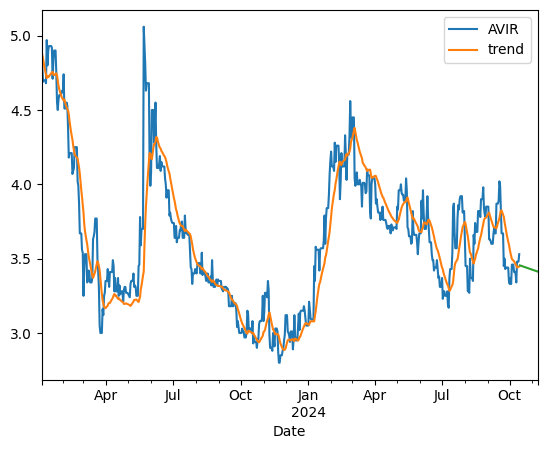

In [11]:
decomp = ExponentialSmoothing(merged_df['AVIR'].dropna(), trend='multiplicative')
fit = decomp.fit(smoothing_level=0.11, smoothing_trend=0.01)
merged_df['trend'] = fit.fittedvalues

fcast = fit.forecast(25)

merged_df[['AVIR','trend']].plot()

fcast.plot()

In [12]:
fcast

,0
2024-10-15,3.454568
2024-10-16,3.452842
2024-10-17,3.451118
2024-10-18,3.449394
2024-10-19,3.447672
2024-10-20,3.445950
2024-10-21,3.444229
2024-10-22,3.442509
2024-10-23,3.440790
2024-10-24,3.439071


In [13]:
fcast.index.name = 'Date'

fcast_df = pd.DataFrame(columns = merged_df.columns, index = fcast.index)
fcast_df['trend'] = fcast.values
fcast_df['AVIR'] = np.nan

fcast_df.head()

,AVIR,trend
Date,,
2024-10-15,NaN,3.454568
2024-10-16,NaN,3.452842
2024-10-17,NaN,3.451118
2024-10-18,NaN,3.449394
2024-10-19,NaN,3.447672


In [14]:
merged_df = pd.concat([merged_df, fcast_df])



In [15]:
## Features 1 - Preços lags

merged_df['lag_3'] = merged_df['AVIR'].shift(3).fillna(method = 'ffill')
merged_df['lag_5'] = merged_df['AVIR'].shift(5)
merged_df['lag_7'] = merged_df['AVIR'].shift(7)
#merged_df['lag_10'] = merged_df['AVIR'].shift(10)
#merged_df['lag_15'] = merged_df['AVIR'].shift(15)
#merged_df['lag_30'] = merged_df['AVIR'].shift(30)


## Criando as Moving averages
# Step 1: Calculate EMAs
merged_df['EMA_9'] = merged_df['AVIR'].ewm(span=9, adjust=False).mean()

# Step 2: Calculate SMAs
merged_df['SMA_5'] = merged_df['AVIR'].rolling(window=5).mean()
merged_df['SMA_15'] = merged_df['AVIR'].rolling(window=15).mean()
merged_df['SMA_30'] = merged_df['AVIR'].rolling(window=30).mean()

# Step 3: Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_df['RSI'] = calculate_rsi(merged_df['AVIR'], window=14)

# Step 4: Calculate MACD
merged_df['EMA_12'] = merged_df['AVIR'].ewm(span=12, adjust=False).mean()
merged_df['EMA_26'] = merged_df['AVIR'].ewm(span=26, adjust=False).mean()
merged_df['MACD'] = merged_df['EMA_12'] - merged_df['EMA_26']
merged_df['MACD_SIGNAL'] = merged_df['MACD'].ewm(span=9, adjust=False).mean()  # Signal line

    ## VAR PERCENTUAL DOS SMAs
pct_5 = merged_df['SMA_5'].dropna().pct_change().iloc[-1]
pct_15 = merged_df['SMA_15'].dropna().pct_change().iloc[-1]
pct_30 = merged_df['SMA_30'].dropna().pct_change().iloc[-1]

for na in range(len(merged_df['SMA_5'].isna())):
    merged_df['SMA_5'] = merged_df['SMA_5'].fillna(merged_df['SMA_5'].shift() * (1 + pct_5))
for na in range(len(merged_df['SMA_15'].isna())):
    merged_df['SMA_15'] = merged_df['SMA_15'].fillna(merged_df['SMA_15'].shift() * (1 + pct_15))
for na in range(len(merged_df['SMA_30'].isna())):
    merged_df['SMA_30'] = merged_df['SMA_30'].fillna(merged_df['SMA_30'].shift() * (1 + pct_30))

merged_df = merged_df.drop(merged_df.index[:14])
merged_df.dropna(subset = 'lag_5', inplace = True)

<ipython-input-15-0c3808e8937e>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['lag_3'] = merged_df['AVIR'].shift(3).fillna(method = 'ffill')


In [16]:
merged_df.tail(15)

,AVIR,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,EMA_12,EMA_26,MACD,MACD_SIGNAL
Date,,,,,,,,,,,,,,
2024-10-05,3.46,3.491799,3.37,3.35,3.44,3.429974,3.390000,3.452000,3.610000,34.328357,3.451610,3.541291,-0.089681,-0.084371
2024-10-06,3.46,3.486720,3.33,3.33,3.44,3.435980,3.416000,3.438000,3.605333,34.328357,3.452901,3.535270,-0.082369,-0.083970
2024-10-07,3.41,3.482171,3.46,3.37,3.35,3.430784,3.424000,3.420667,3.599000,46.000004,3.446301,3.525990,-0.079690,-0.083114
2024-10-08,3.41,3.472549,3.46,3.33,3.33,3.426627,3.440000,3.418000,3.592667,40.000011,3.440716,3.517399,-0.076683,-0.081828
2024-10-09,3.40,3.463920,3.46,3.46,3.37,3.421302,3.428000,3.411333,3.583667,46.153851,3.434452,3.508702,-0.074250,-0.080312
2024-10-10,3.34,3.455074,3.41,3.46,3.33,3.405041,3.404000,3.405333,3.571333,38.636355,3.419921,3.496206,-0.076285,-0.079507
2024-10-11,3.48,3.440484,3.41,3.46,3.46,3.420033,3.408000,3.408000,3.565000,53.448270,3.429164,3.495006,-0.065842,-0.076774
2024-10-12,3.48,3.442940,3.40,3.41,3.46,3.432026,3.422000,3.410667,3.558667,53.448270,3.436985,3.493894,-0.056909,-0.072801
2024-10-13,3.48,3.445166,3.34,3.41,3.46,3.441621,3.436000,3.413333,3.545667,53.448270,3.443603,3.492865,-0.049262,-0.068093


In [17]:
merged_df = merged_df[['AVIR','trend','lag_3','lag_5','lag_7', 'EMA_9','SMA_5','SMA_15','SMA_30','RSI','MACD','MACD_SIGNAL']]

In [18]:
## Separação treino test
train_size = int(len(merged_df)*0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

test_df

,AVIR,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,MACD,MACD_SIGNAL
Date,,,,,,,,,,,,
2024-06-13,3.70,3.761358,3.79,3.70,3.80,3.764928,3.778000,3.755333,3.706333,53.488377,0.009656,0.002911
2024-06-14,3.61,3.754955,3.92,3.70,3.70,3.733943,3.760000,3.755333,3.703000,47.727267,-0.003008,0.001727
2024-06-15,3.61,3.739196,3.78,3.79,3.70,3.709154,3.724000,3.751333,3.700000,47.727267,-0.012896,-0.001197
2024-06-16,3.61,3.725029,3.70,3.92,3.70,3.689323,3.662000,3.747333,3.698667,47.727267,-0.020495,-0.005057
2024-06-17,3.53,3.712294,3.61,3.78,3.79,3.657459,3.612000,3.738000,3.694667,34.745761,-0.032598,-0.010565
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15,NaN,3.454568,3.48,3.34,3.41,3.459297,3.488197,3.425344,3.523036,69.230766,-0.038721,-0.057519
2024-10-16,NaN,3.452842,3.48,3.48,3.40,3.459297,3.514592,3.431365,3.511775,66.666667,-0.038721,-0.053760
2024-10-17,NaN,3.451118,3.53,3.48,3.34,3.459297,3.541186,3.437397,3.500550,72.727263,-0.038721,-0.050752


In [19]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('AVIR', axis=1))
test_scaled = scaler.transform(test_df.drop('AVIR', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop('AVIR', axis=1).columns, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop('AVIR', axis=1).columns, index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['AVIR'] = train_df['AVIR']
test_scaled_df['AVIR'] = test_df['AVIR']

forecast_df = test_scaled_df[test_scaled_df['AVIR'].isna()]

test_scaled_df = test_scaled_df.dropna()

# Split the scaled data into Features and Label
y_train = train_scaled_df['AVIR']
X_train = train_scaled_df.drop('AVIR', axis=1)
y_test = test_scaled_df['AVIR']
X_test = test_scaled_df.drop('AVIR', axis=1)

#forecast_df ; X_forecast, df de forecat do XGBoost
X_forecast = forecast_df.drop('AVIR', axis=1)
X_forecast

,trend,lag_3,lag_5,lag_7,EMA_9,SMA_5,SMA_15,SMA_30,RSI,MACD,MACD_SIGNAL
Date,,,,,,,,,,,
2024-10-15,0.304049,0.300885,0.238938,0.269912,0.287761,0.313726,0.262048,0.316647,0.784260,0.357091,0.333917
2024-10-16,0.303127,0.300885,0.300885,0.265487,0.287761,0.326307,0.265134,0.310399,0.749553,0.357091,0.340762
2024-10-17,0.302205,0.323009,0.300885,0.238938,0.287761,0.338983,0.268225,0.304171,0.831587,0.357091,0.346239
2024-10-18,0.301284,0.323009,0.300885,0.300885,0.287761,0.351755,0.271322,0.297963,0.676781,0.357091,0.350620
2024-10-19,0.300363,0.323009,0.323009,0.300885,0.287761,0.364624,0.274424,0.291774,0.676781,0.357091,0.354125


In [20]:
## Modelo XGBoost
import xgboost as xgb

In [21]:
from sklearn.metrics import make_scorer
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape, greater_is_better=False)  # MAPE should be minimized

In [22]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
}

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=1, random_state = 42)
clf = GridSearchCV(model, parameters, scoring={'MAPE': mape_scorer}, refit = 'MAPE', cv=5)

clf.fit(X_train, y_train, verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
Best validation score = -2.783667724342633


In [23]:
reg = xgb.XGBRegressor(
    gamma = 0.001,
    learning_rate = 0.05,
    max_depth = 8,
    n_estimators = 300,
    random_state = 42
)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

##

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100


print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

Mean Squared Error (MSE): 0.008562981638208057
Mean Absolute Error (MAE): 0.07129440384526405
R2 Score: 0.8141006178967938
Explained Variance Score: 0.8144651417413987
Mean Absolute Percentage Error (MAPE): 1.984246659105858
Mean Percentage Error (MPE): 0.11249271419453506


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

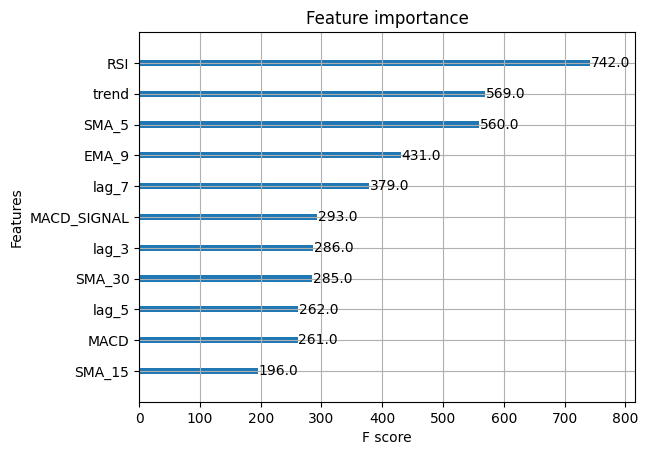

In [24]:
from xgboost import plot_importance

plot_importance(reg)

In [25]:
y_forecast = reg.predict(X_forecast)

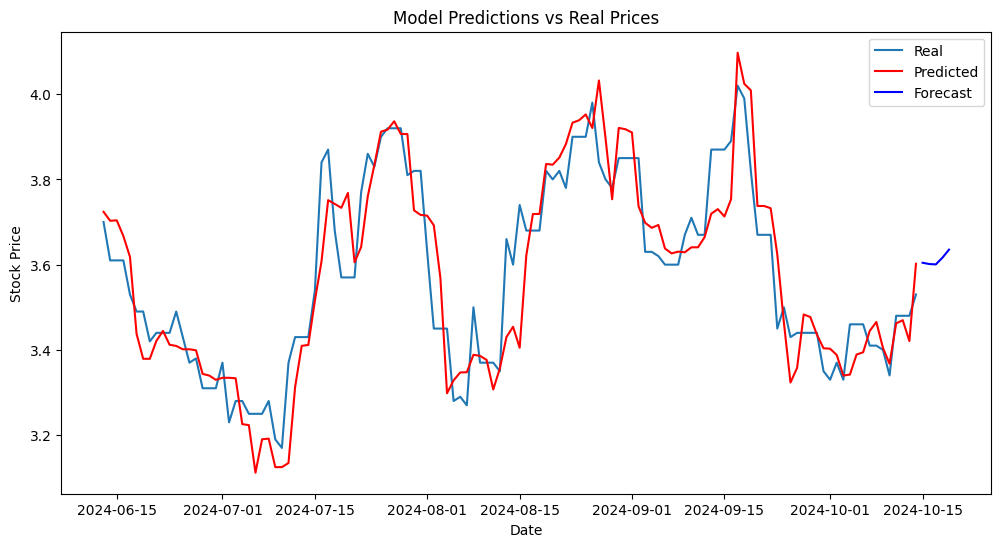

In [26]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

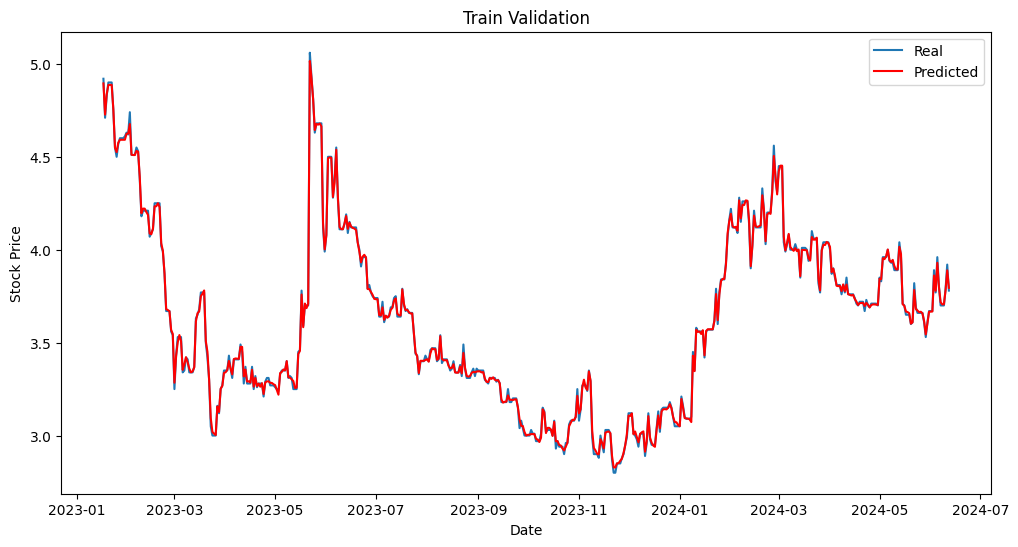

In [27]:
y_pred_train = reg.predict(X_train)

# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train_scaled_df.index, y_train, label='Real')
plt.plot(train_scaled_df.index, y_pred_train, color='red', label='Predicted')
#plt.plot(forecast_df.index, y_forecast, color = 'blue', label = 'Forecast')
plt.title('Train Validation')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()